# Exercise Sheet 3 - Covid-19 Classification using Transfer Learning

In the first part of the exercise you will train ResNets from scratch, analyze the effects of deeper models with small training data and use data augmentations. In the second part, you will solve the same task using pretrained ResNets (from ImageNet - pretrained on natural images; and RadImageNet - pretrained on the medical imaging domain).

- Check out the [RadImageNet publication](https://doi.org/10.1148/ryai.210315).


Implementation
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs and answer the **questions** asked. In addition to the python packages loaded below, you are allowed to use any packages you want.

**Importing required libraries:**

We have provided the most essential libraries to be used for the exercise. Feel free to add modules as per your requirement.

In [1]:
import os
from glob import glob
from IPython.display import FileLink

import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms

%pip install barbar

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Setting up the device (make sure device returns "cuda" to use of the GPUs)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Getting the Required Functionalities

We first download and import `ex3_utils.py`, which in which functions for training evaluation etc. are already implemented (similar to the previous exercise). You can download this file and inspect it on your computer to understand the functions it contains.

You can download it from Stud.IP (it's provided there in the same folder as this notebook.)

In [3]:
# DO NOT CHANGE
import ex3_utils as utils

### Data Preparation

The dataset is provided for you in the Project Folder. If you're working on your local machines you can download it as shown below.

In [4]:
# set a directory to save checkpoints, feel free to change this
root_dir = "./"

# DO NOT CHANGE
# Check if $PROJECT exists
project_path = os.path.expandvars("$PROJECT")

if os.path.exists(project_path):
    # On cluster: use $PROJECT paths
    data_folder = os.path.join(project_path, "data", "Ex3", "covid19")
    model_dir = os.path.join(project_path, "models", "Ex3", "model_weights")
else:
    # Local machine
    data_folder = os.path.join(root_dir, "covid19")
    model_dir = os.path.join(root_dir, "model_weights")
    os.makedirs(model_dir, exist_ok=True)
    !wget https://owncloud.gwdg.de/index.php/s/dcvhmxtksDDDtK8/download -O covid19-xray.zip 
    !unzip -q "covid19-xray.zip" -d {data_folder}

print(f"Data folder: {data_folder}")
print(f"Model weights folder: {model_dir}")

Data folder: /projects/scc/UGOE/UXEI/UMIN/scc_umin_pape/scc_umin_pape_dlforcv2526/dir.project/data/Ex3/covid19
Model weights folder: /projects/scc/UGOE/UXEI/UMIN/scc_umin_pape/scc_umin_pape_dlforcv2526/dir.project/models/Ex3/model_weights


**Data exploration**

The data is stored in the project folder (or root_dir) and contains four subfolders, namely `train`, `val`, `test` and `unknown` with training / validation / testing split and the hold-out test set, respectively. Each of these (except `unknown`) contains subfolders with the images for the respective classes. As a first step, we will visualize some of the images and labels from the training data.

We will not use the `unknown` directory for training or evaluation, but will only use it for prediction with the best model at the end.

In [5]:
# DO NOT CHANGE
# Checking the number of classes
train_class_dirs = glob(os.path.join(data_folder, "train", "*"))
val_class_dirs = glob(os.path.join(data_folder, "val", "*"))
test_class_dirs = glob(os.path.join(data_folder, "test", "*"))
assert len(train_class_dirs) == len(val_class_dirs) == len(test_class_dirs) == 3

In [6]:
# DO NOT CHANGE
# Checking the expected structure of all images
image_paths = glob(os.path.join(data_folder, "**", "*.jpg"), recursive=True)
assert len(image_paths) == (450 + 150 + 225 + 5607), len(image_paths)  # 450 train samples, 150 val samples, 225 test samples, 5607 unlabeled samples (hold-out test)

Let's plot samples from each class in the training set:

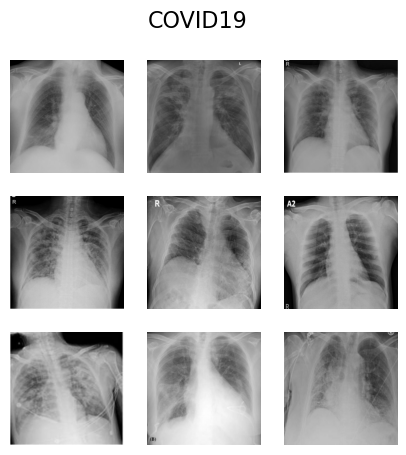

Amount of images: 150


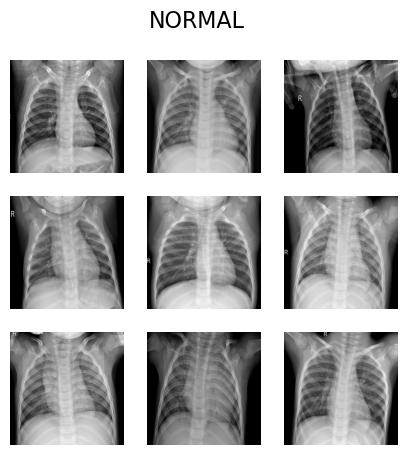

Amount of images: 150


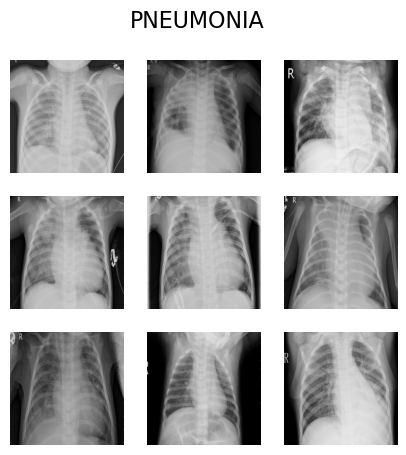

Amount of images: 150

Amount of classes: 3


In [7]:
# Classes available for the task
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = 3

# TODO: YOUR SOLUTION HERE
for class_single in classes:
    fig, axes = plt.subplots(3,3, figsize=(5, 5))
    fig.suptitle(str(class_single), fontsize=16)
    class_dir = os.path.join(data_folder, "train", class_single)
    class_images = glob(os.path.join(class_dir, "*.jpg"))
    for i, ax in zip(range(9), axes.flat):
        image = imageio.imread(class_images[i])
        ax.imshow(image)
        ax.axis("off")
    plt.show()
    print("Amount of images: "+ str(len(class_images)))
train_dirs = os.path.join(data_folder, "train", "")
class_dirs = glob(os.path.join(train_dirs, "*"))
print("\nAmount of classes: "+str(len(class_dirs)))

You should see x-ray images from each class and their corresponding labels in their titles. To reflect on our understanding of the dataset, please answer the following **questions**:
- How many classes are provided in the datasets?
  - 3
- Are the images balanced along all the classes in the respective data splits?
  - Yes, there are 150 images per class

Let's set the directories for the respective datasets

In [8]:
# Splits for the dataset 
train_dir = os.path.join(data_folder, "train")
val_dir = os.path.join(data_folder, "val")
test_dir = os.path.join(data_folder, "test")
unknown_dir = os.path.join(data_folder, "unknown")

Now, we obtain the statistics (mean and standard deviation) from the training dataset to be used for normalizing the datasets

In [9]:
# DO NOT CHANGE
train_images = []
for class_name in classes:
    train_images.extend(glob(os.path.join(train_dir, class_name, "*.jpg")))

to_tensor = torchvision.transforms.ToTensor()
imgs = torch.stack([to_tensor(imageio.imread(im)) for im in train_images])
print(imgs.shape)

# And then compute the mean and standard deviation independently for the image channels.
# (The channels are stored in dim=1, by excluding this below we achieve this.)
mean = torch.mean(imgs, dim=(0, 2, 3))
std = torch.std(imgs, dim=(0, 2, 3))

# Delete the images again in order to save memory.
del imgs

print(mean)
print(std)

torch.Size([450, 3, 512, 512])
tensor([0.4949, 0.4952, 0.4957])
tensor([0.2298, 0.2298, 0.2298])


In [10]:
train_dataset_mean = mean
train_dataset_std = std

**Implement PyTorch dataloader**

As a next step, we implement a `torch.utils.data.Dataset` followed by the `torch.utils.data.DataLoader` to have access to our data during training, validation and testing. In our case, the data is stored in a format that is already compatible with `torchvision.datasets.ImageFolder`.

To use the image data in PyTorch it first needs to be transformed. You can use the transformations from [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html) for this. Here, we need to:
- Convert the image data to a `torch.tensor` (`transforms.ToTensor`)
- Standardize the inputs based on their data statistics (`transforms.Normalize`)
- Resize the images (`transforms.Resize`). Note that resizing is not strictly necessary, but will speed up training and resize the images to a size that better matches the ImageNet pretraining data.

To combine several transforms together, you can use `torchvision.transforms.Compose` by passing the list of 'transform' objects to compose.

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [12]:
# We resize the images to the size 256 x 256 to speed up training
height = width = 256

# Get the usual transforms to have the inputs from dataloaders as expected
def get_transforms(height, width):
    # TODO: YOUR CODE HERE 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        transforms.Resize((height, width))])
    return transform

In [13]:
# Batch size
batch_size = 15  # TODO: YOUR CHOICE HERE

# Datasets
# TODO: YOUR SOLUTION HERE
train_dataset = datasets.ImageFolder(root=train_dir, transform=get_transforms(height, width))
val_dataset = datasets.ImageFolder(root=val_dir, transform=get_transforms(height, width))
test_dataset = datasets.ImageFolder(root=test_dir, transform=get_transforms(height, width))

# Dataloaders
# TODO: YOUR SOLUTION HERE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Now let's visualize the images after transformation as they are returned from the training loader.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.57825315..1.5991571].


NORMAL,  COVID19,  COVID19,  PNEUMONIA,  NORMAL,  COVID19,  COVID19,  PNEUMONIA,  PNEUMONIA,  COVID19,  COVID19,  COVID19,  PNEUMONIA,  COVID19,  PNEUMONIA, 


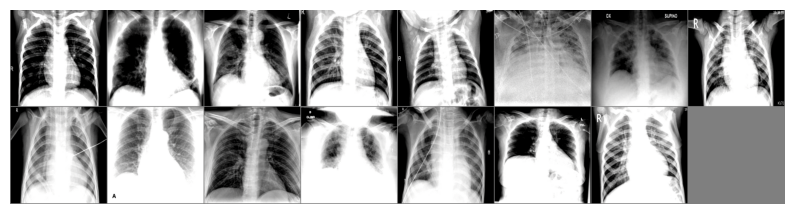

In [14]:
# Function to show images
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5  # unnormalise
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Obtain random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

## Architecture

We will use the ResNet implementation from torchvision, see https://pytorch.org/vision/stable/models.html, for this exercise.

- We start with the smallest ResNet model, the ResNet18 (https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)
- And will then use deeper ResNets to explore how well larger models can be trained on a small dataset.
- To use random weight initialization (in order to train from scratch), you can just create models without passing additional arguments like so: `torchvision.models.<MODEL_NAME>()`.

We need to adapt the model to fit with our purpose. For this, we must change the output dimension of the last fully-connected layer to consider the number of classes in our problem. Let's check the last layer out.

In [15]:
# Let's get the resnet18 architecture and understanding the backbone (in order to adapt it to our problem)
# TODO: YOUR SOLUTION HERE
model = torchvision.models.resnet18()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We see above that there is a component called `fc` that consists of a `Linear` layer. To make use of ResNet18 for our classification task, we need to change the `out_features` of the linear layer to the number of classes of our problem. In our case, it's `num_classes` (=3).

In [16]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


To replace the last layer (classification layer) you can use the following code. (Here we provide a stand-alone code snippet)

```python
import torchvision
import torch.nn as nn

model = torchvision.models.resnet18()

# Let's replace the "fully connected" layer to match our expected output classes
model.fc = nn.Linear(<INPUT_FEATURES>, <OUTPUT_CLASSES>)
model.to(device)
```

In [17]:
# Replacing the last layer(s) of ResNet18 to match our number of classes
# TODO: YOUR SOLUTION HERE
model.fc = nn.Linear(512, 3)
model = model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "resnet18"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)

The model checkpoint will be saved here:  ./covid-19-resnet18-from-scratch.pt


If you now display the model (using `print(model)`) you should see that its last layer has been updated.

In [18]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

Let's train the model for 10 epochs, using the `Adam` optimizer, `CrossEntropyLoss` as the criterion (loss function) and a learning rate scheduler (e.g. `ReduceLROnPlateau`).

In [19]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [20]:
# Clearing the GPU cache
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # optimizer
scheduler = ReduceLROnPlateau(optimizer)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, model, 10, criterion, optimizer, scheduler, early_stopping, device)

Starting training from scratch with network:  resnet18
450/450: [==============================>.] - ETA 0.4ss
Epoch: 1
Training Loss: 0.615 , Training Accuracy:0.758 => Validation Loss: 1.553, Validation Accuracy: 0.600 
450/450: [==============================>.] - ETA 0.1s
Epoch: 2
Training Loss: 0.620 , Training Accuracy:0.756 => Validation Loss: 0.646, Validation Accuracy: 0.727 
450/450: [==============================>.] - ETA 0.1s
Epoch: 3
Training Loss: 0.416 , Training Accuracy:0.838 => Validation Loss: 0.763, Validation Accuracy: 0.773 
EarlyStopping Counter: 1 out of 5
450/450: [==============================>.] - ETA 0.1s
Epoch: 4
Training Loss: 0.328 , Training Accuracy:0.889 => Validation Loss: 0.393, Validation Accuracy: 0.840 
450/450: [==============================>.] - ETA 0.1s
Epoch: 5
Training Loss: 0.262 , Training Accuracy:0.902 => Validation Loss: 0.450, Validation Accuracy: 0.860 
EarlyStopping Counter: 1 out of 5
450/450: [==============================>.] - 

Now, let's see how the accuracy and loss plots look for our training.

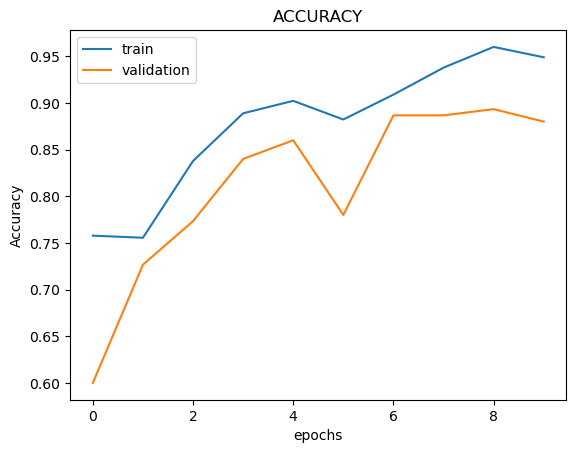

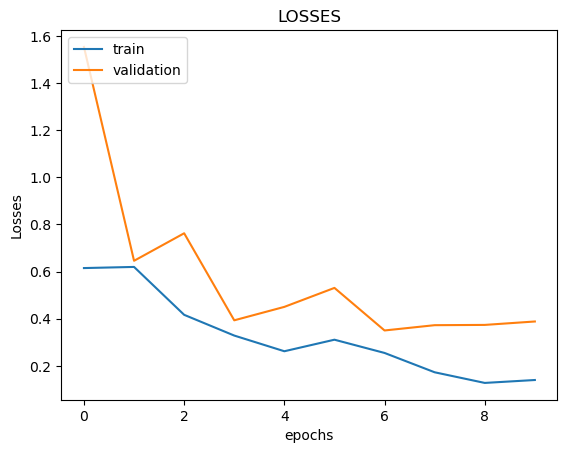

In [21]:
# Training and validation accuracy plots
# TODO: YOUR SOLUTION HERE
utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")


# Training and validation loss plots
# TODO: YOUR SOLUTION HERE
utils.get_metric_plots(losses, val_losses, "Losses")

### Evaluation on the test set

Let's check the test accuracy and confusion matrix. All the required functionality is already provided in `ex3_utils.py` and you just need to read the corresponding functions to understand how to call them here.

In [22]:
# Loading the best model for inference (NOTE: you should load the checkpoints to the expected model architecture, else you might get some mismatch errors)
# TODO: YOUR SOLUTION HERE
model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
model = model.to(device)

# Provide the testing dataset wrapped in a dataloader to check for inference
# TODO: YOUR SOLUTION HERE
correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

Accuracy of ./covid-19-resnet18-from-scratch.pt on the Test Images: 89 %


In [23]:
# Get the confusion matrix for the test dataset
# TODO: YOUR SOLUTION HERE
cm = utils.get_confusion_matrix(classes, test_loader, model, device)

# See the precision, recall and accuracy per class for the test dataset
# TODO: YOUR SOLUTION HERE
utils.check_precision_recall_accuracy(cm, classes)

COVID19 - recall :  0.9259259  precision :  1.0  accuracy :  0.97333336
NORMAL - recall :  0.875  precision :  0.84  accuracy :  0.9066667
PNEUMONIA - recall :  0.875  precision :  0.84  accuracy :  0.9066667


0.8933333333333333


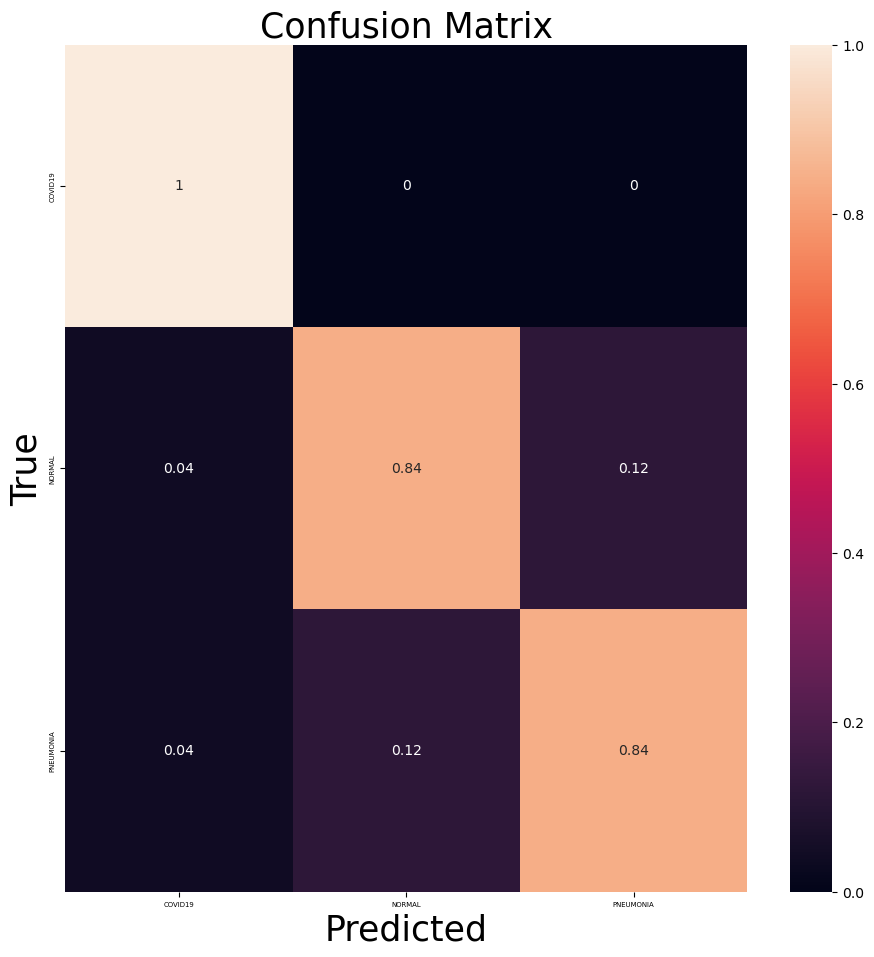

In [24]:
# Check the confusion matrix heatmap to visually see the evaluation on the test set
# TODO: YOUR SOLUTION HERE
utils.visualize_confusion_matrix(cm, classes, correct, total)

Now let's try training deeper ResNet architectures using the same hyperparameters from above:
- Train and evaluate a ResNet34 from scratch.
- Train and evaluate a ResNet50 from scratch.

The model checkpoint will be saved here:  ./covid-19-ResNet34-from-scratch.pt
Starting training from scratch with network:  ResNet34
450/450: [==============================>.] - ETA 0.1s
Epoch: 1
Training Loss: 0.581 , Training Accuracy:0.771 => Validation Loss: 1.483, Validation Accuracy: 0.520 
450/450: [==============================>.] - ETA 0.1s
Epoch: 2
Training Loss: 1.111 , Training Accuracy:0.631 => Validation Loss: 0.788, Validation Accuracy: 0.573 
450/450: [==============================>.] - ETA 0.1s
Epoch: 3
Training Loss: 0.554 , Training Accuracy:0.758 => Validation Loss: 0.494, Validation Accuracy: 0.793 
450/450: [==============================>.] - ETA 0.1s
Epoch: 4
Training Loss: 0.383 , Training Accuracy:0.862 => Validation Loss: 0.478, Validation Accuracy: 0.833 
450/450: [==============================>.] - ETA 0.1s
Epoch: 5
Training Loss: 0.324 , Training Accuracy:0.889 => Validation Loss: 0.534, Validation Accuracy: 0.813 
EarlyStopping Counter: 1 out of 5
450

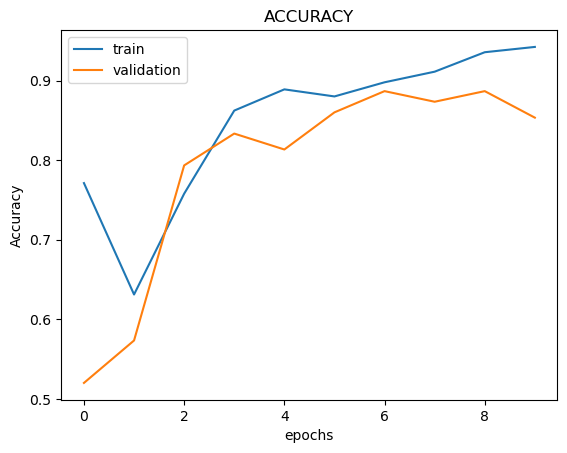

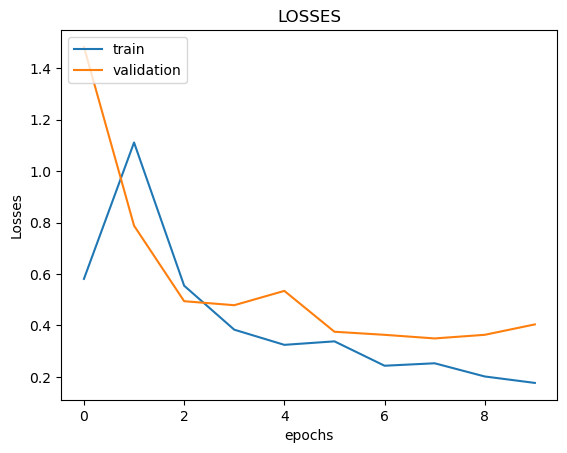

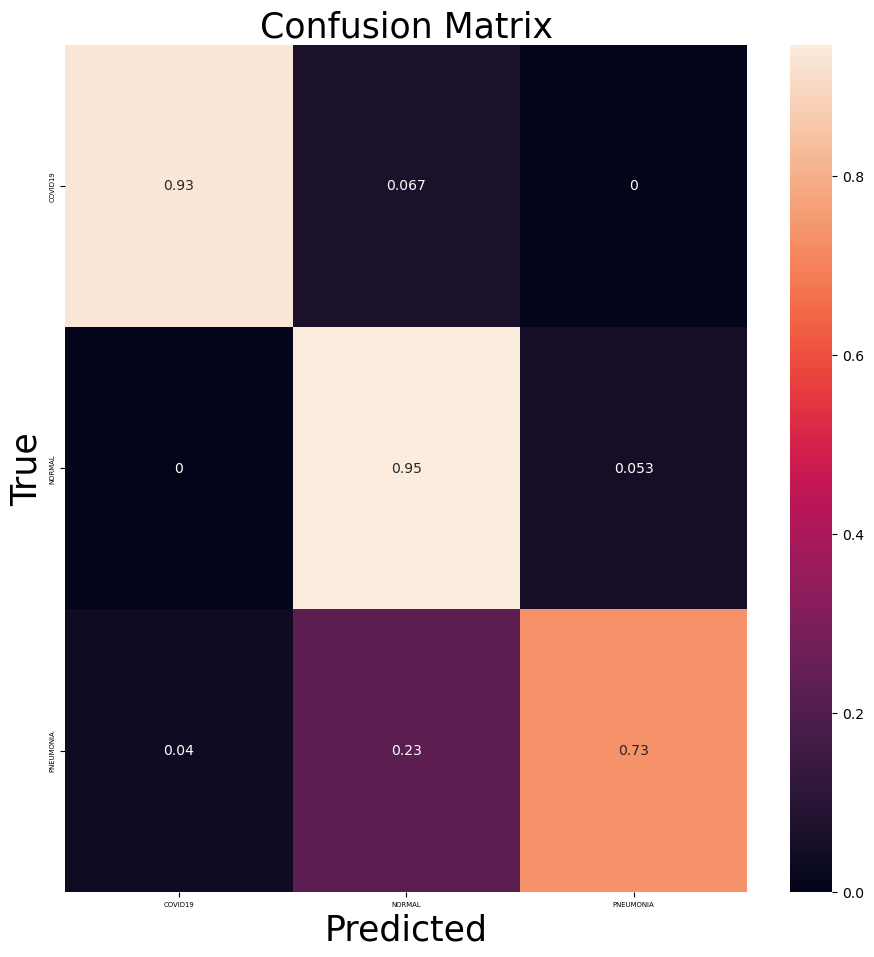

In [25]:
# TODO: YOUR SOLUTIONS HERE
model = torchvision.models.resnet34()
model.fc = nn.Linear(512, 3)
model = model.to(device)
model_name = "ResNet34"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()

print("Starting training from scratch with network: ", model_name)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer)

early_stopping = utils.EarlyStopping(checkpoint_path)

accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, model, 10, criterion, optimizer, scheduler, early_stopping, device)

utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")
utils.get_metric_plots(losses, val_losses, "Losses")

model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
model = model.to(device)

correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, model, device)
utils.check_precision_recall_accuracy(cm, classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

# HINT: (for the workflow)
#    - Start with training a ResNet34:
#          - Updating the last layers (training the network from scratch)
#          - REMEMBER: Save the respective checkpoints uniquely, and initialize the early stopping with them.
#          - Use the expected hyperparameters for training
#          - Observe the loss and accuracy curves for training and validation
#    - Next, train a ResNet50 (following the same suggestion as above)
#    - Finally, evaluate both the trained models from above on the test set and answer the questions.

The model checkpoint will be saved here:  ./covid-19-ResNet50-from-scratch.pt
Starting training from scratch with network:  ResNet50
450/450: [==============================>.] - ETA 0.2s
Epoch: 1
Training Loss: 0.847 , Training Accuracy:0.596 => Validation Loss: 3.429, Validation Accuracy: 0.333 
450/450: [==============================>.] - ETA 0.2s
Epoch: 2
Training Loss: 1.238 , Training Accuracy:0.478 => Validation Loss: 0.748, Validation Accuracy: 0.593 
450/450: [==============================>.] - ETA 0.2s
Epoch: 3
Training Loss: 0.749 , Training Accuracy:0.669 => Validation Loss: 0.768, Validation Accuracy: 0.607 
EarlyStopping Counter: 1 out of 5
450/450: [==============================>.] - ETA 0.2s
Epoch: 4
Training Loss: 0.586 , Training Accuracy:0.753 => Validation Loss: 0.562, Validation Accuracy: 0.800 
450/450: [==============================>.] - ETA 0.2s
Epoch: 5
Training Loss: 0.503 , Training Accuracy:0.798 => Validation Loss: 0.489, Validation Accuracy: 0.820 
450

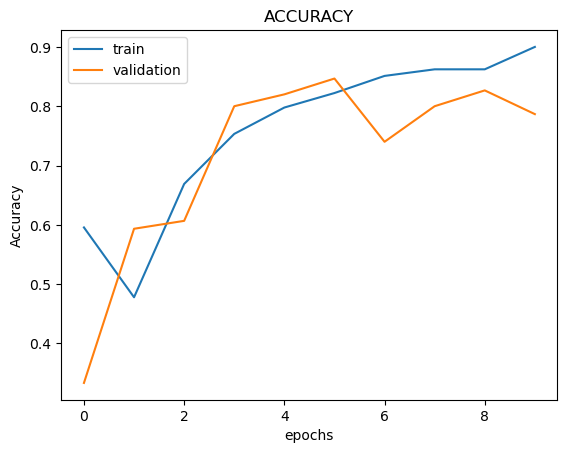

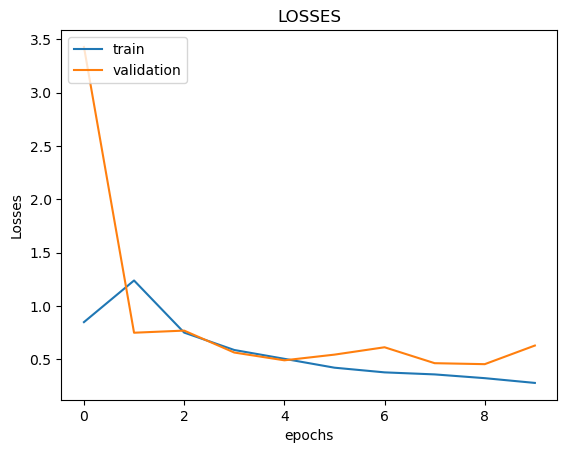

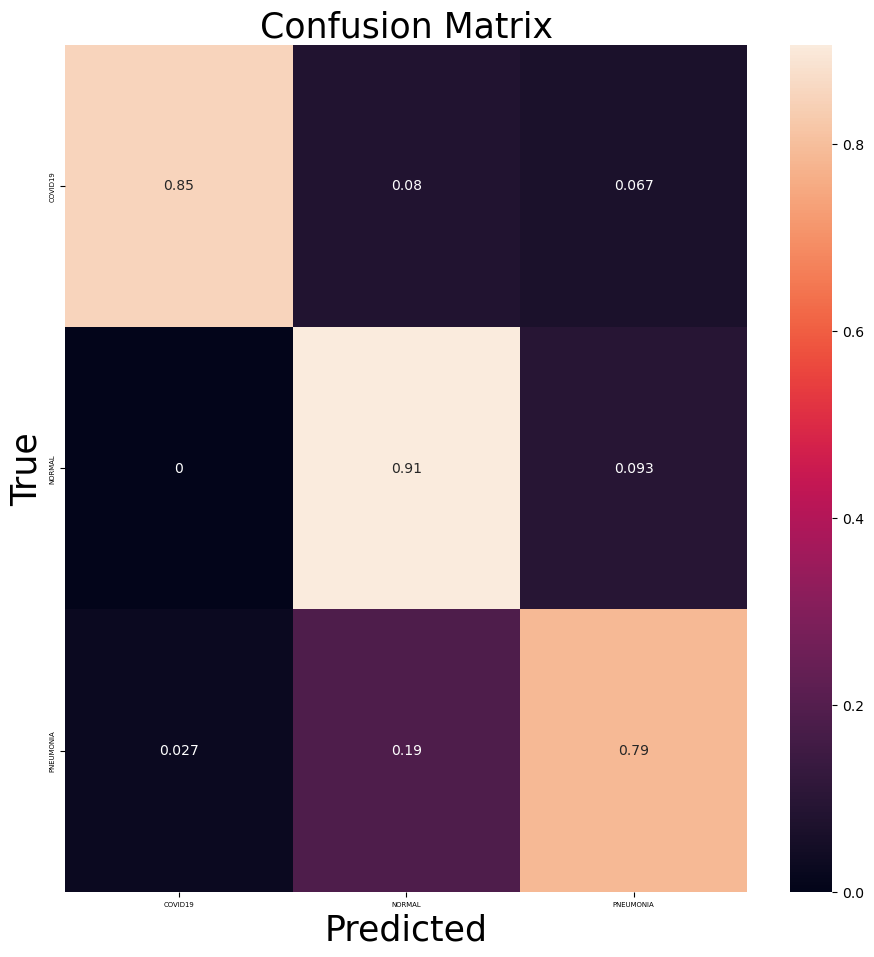

In [26]:
# train a ResNet50 (following the same suggestion as above)
model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, 3)
model = model.to(device)
model_name = "ResNet50"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()

print("Starting training from scratch with network: ", model_name)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer)

early_stopping = utils.EarlyStopping(checkpoint_path)

accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, model, 10, criterion, optimizer, scheduler, early_stopping, device)

utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")
utils.get_metric_plots(losses, val_losses, "Losses")

model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
model = model.to(device)

correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, model, device)
utils.check_precision_recall_accuracy(cm, classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

**Questions**:

1. How does the performance of the three architectures compare to each other? Are there any specific patterns you can see in the confusion matrices?
2. Is there a correlation between the dataset size and depth of the network?
3. Given these observations, which model would you prefer for training on a small dataset from scratch?

**Answers**
1. ResNet18 and ResNet34 performs the best, and ResNet50 is the worst. From the confusion matrices, ResNet18 and ResNet34 seem to identify COVID-19 more correctly, while ResNet50 makes more mistakes.
2. Yes, if we are given larger datasets, it makes sense to use larger models and if we are given smaller datasets it makes sense to use smaller models.
3. ReNet18 since it has a very similar accuracy to ResNet34 and in comparison is more efficient when training with the data since it is smaller.

#### Now let's try with **Data Augmentation**

A common strategy when dealing with small datasets is to add data augmentations.

Let's try a few augmentations from [torchvision.transforms](https://pytorch.org/vision/main/transforms.html) that do not significantly distort the data (stay on the data manifold) and train a ResNet50. Here, we want to see if augmentations allow us to train deeper CNNs. 
Common augmentations for data augmentation are:
- flipping the inputs along the axes.
- changing the brightness, contrast and saturation of the inputs.
- adding small noise to the input.

You can try different combinations of augmentations here. You can add augmentations by updating the `transform` passed to the train dataset. You can again use `Compose` to chain augmentations. Play around with different augmentations here but if you can not find any data augmentations that improve model performance, move on to the next task. 

Note; you should only introduce augmentation for the training and validation datasets, **not** for the test dataset. Otherwise the evaluation between models is not consistent anymore.

In [27]:
# TODO: YOUR SOLUTIONS HERE
def get_transforms2(height, width):
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(0.7, 0.5, 0.3),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)])
    return transform

# HINT:
#    - Training a ResNet50 (incorporating data augmentation strategies)
#    = (the training workflows are the same as above)

We need to apply the new transforms to the dataset and then use our dataloader. Let's reuse our scripts from above, now with the added data augmentation strategies.

In [28]:
# TODO: YOUR SOLUTION HERE
# Datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=get_transforms2(height, width))
val_dataset = datasets.ImageFolder(root=val_dir, transform=get_transforms2(height, width))

# TODO: YOUR SOLUTION HERE
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Now, we are ready to train the ResNet50 with data augmentations. Let's train for longer (30 epochs) here, with the same hyperparameters as before, and evaluate the model on the test set.

The model checkpoint will be saved here:  ./covid-19-ResNet50-from-scratch.pt
Starting training from scratch with network:  ResNet50
450/450: [==============================>.] - ETA 0.2s
Epoch: 1
Training Loss: 1.083 , Training Accuracy:0.420 => Validation Loss: 1.397, Validation Accuracy: 0.333 
450/450: [==============================>.] - ETA 0.2s
Epoch: 2
Training Loss: 1.097 , Training Accuracy:0.427 => Validation Loss: 0.904, Validation Accuracy: 0.500 
450/450: [==============================>.] - ETA 0.2s
Epoch: 3
Training Loss: 1.056 , Training Accuracy:0.471 => Validation Loss: 0.905, Validation Accuracy: 0.440 
EarlyStopping Counter: 1 out of 5
450/450: [==============================>.] - ETA 0.2s
Epoch: 4
Training Loss: 0.901 , Training Accuracy:0.562 => Validation Loss: 0.739, Validation Accuracy: 0.727 
450/450: [==============================>.] - ETA 0.2s
Epoch: 5
Training Loss: 0.886 , Training Accuracy:0.576 => Validation Loss: 0.914, Validation Accuracy: 0.560 
Ear

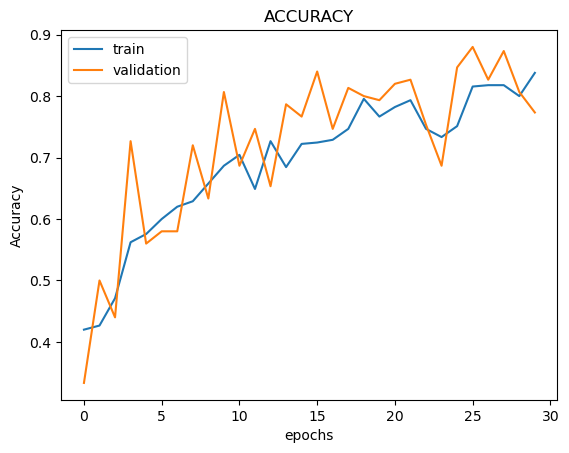

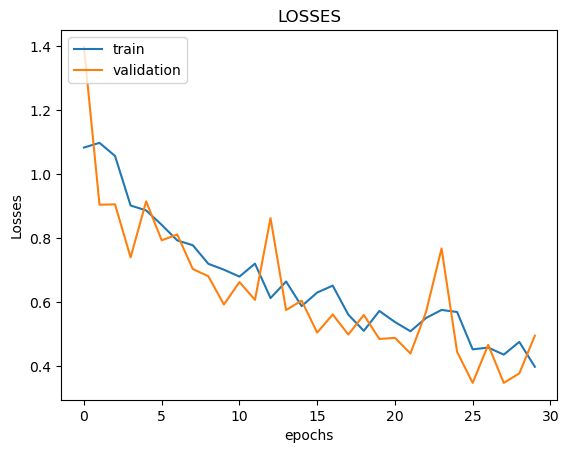

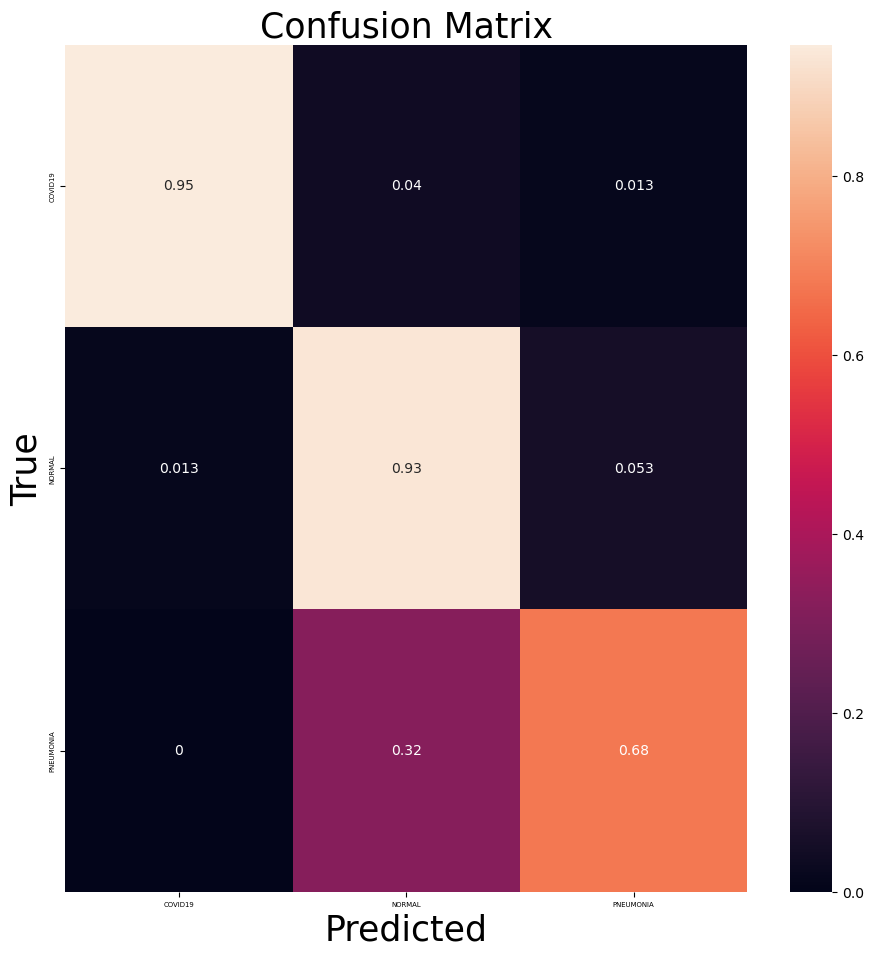

In [29]:
# TODO: YOUR SOLUTION HERE
model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, 3)
model = model.to(device)
model_name = "ResNet50"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()

print("Starting training from scratch with network: ", model_name)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer)

early_stopping = utils.EarlyStopping(checkpoint_path)

accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, model, 30, criterion, optimizer, scheduler, early_stopping, device)

utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")
utils.get_metric_plots(losses, val_losses, "Losses")

model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
model = model.to(device)

correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, model, device)
utils.check_precision_recall_accuracy(cm, classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

**Questions**:

1. Does the effect of data augmentation match your expectation?
2. Are there other kinds of data augmentation that would make sense for this dataset? Think about augmentations that "leave the data manifold".

**Answers**:
1. Yes, the model with augmentation performs slightly better than the normal ResNet50, which is expected.
2. Data augmentation creates more varied and challenging images, which helps the model learn more robust features. For example horizontal flip.

## ImageNet

The [ImageNet project](https://www.image-net.org/) provides a large-scale dataset with natural images. There exist different version of this dataset, the largest using 14 million annotated images for image classification with over 20,000 categories. 

This dataset has been used by the ImageNet Scale Visual Recognition Challenge ([ILSVRC](https://image-net.org/challenges/LSVRC/#:~:text=The%20ImageNet%20Large%20Scale%20Visual,image%20classification%20at%20large%20scale.)) to benchmark classification algorithms competing to improve classification. The version fo the dataset used for this classification contains a million training images with 1,000 categeories (and corresponds to the version fo the dataset we discussed in the lecture).

`torchvision.models` has a pool of neural networks, for which pretrained ImageNet weights are also available. To make use of pretrained models, we need to preprocess the images based on the mean and standard deviation of ImageNet (this step is critical!). The statistics for ImageNet are provided [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#:~:text=1.0%5D%20and%20then-,normalized%20using%20mean%3D%5B0.485%2C%200.456%2C%200.406%5D%20and%20std%3D%5B0.229%2C%200.224%2C%200.225%5D.,-Next).

### ImageNet transfer learning for ResNet50

We will now check if transfer learning from ImageNet leads to improvements for our dataset. Here, we will focus on the ResNet50 as we have seen before that without transfer learning its performance is worse compared to smaller architectures for our dataset.

There are two different approaches for how we can fine-tune a CNN initialized with pretrained weights:
1. Update the weights for all layers of the network. For this approach we initialize with pretrained weights but otherwise train the network as before. See this code snippet:

    ```python
    model_dir = "./model_weights"
    weights_path = os.path.join(model_dir, "resnet50-0676ba61.pth")

    model = torchvision.models.resnet50(weights=None)  # or pretrained=False in older torchvision

    # Load the state dictionary
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    # Let's replace the "fully connected" layer to match our expected output classes
    model.fc = nn.Linear(<INPUT_FEATURES>, <OUTPUT_CLASSES>)
    model.to(device)

    # Train the network as usual
    ```

    or if you are not using Jupyter HPC: 

    ```python
    import torchvision
    import torch.nn as nn

    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    # Let's replace the "fully connected" layer to match our expected output classes
    model.fc = nn.Linear(<INPUT_FEATURES>, <OUTPUT_CLASSES>)
    model.to(device)

    # Train the network as usual
    ```
    
2. Only update the weights of the last layer (classification layer). In this case we would "freeze" the pretrained network and use it as a fixed feature extractor. This is achieved by disabling parameter updates for all but the last layer of the network.

We will start with the first approach (fine-tuning the full network).

In [30]:
project_path = os.path.expandvars("$PROJECT")
print(os.path.exists(project_path))

True


The model checkpoint will be saved here:  ./covid-19-ResNet50_Imagetrained-from-scratch.pt
Starting training from scratch with network:  ResNet50_Imagetrained
450/450: [==============================>.] - ETA 0.2s
Epoch: 1
Training Loss: 0.471 , Training Accuracy:0.816 => Validation Loss: 0.336, Validation Accuracy: 0.887 
450/450: [==============================>.] - ETA 0.2s
Epoch: 2
Training Loss: 0.666 , Training Accuracy:0.727 => Validation Loss: 0.597, Validation Accuracy: 0.620 
EarlyStopping Counter: 1 out of 5
450/450: [==============================>.] - ETA 0.3ss
Epoch: 3
Training Loss: 0.395 , Training Accuracy:0.836 => Validation Loss: 0.173, Validation Accuracy: 0.947 
450/450: [==============================>.] - ETA 0.5ss
Epoch: 4
Training Loss: 0.356 , Training Accuracy:0.849 => Validation Loss: 0.229, Validation Accuracy: 0.913 
EarlyStopping Counter: 1 out of 5
450/450: [==============================>.] - ETA 0.3ss
Epoch: 5
Training Loss: 0.290 , Training Accuracy:0

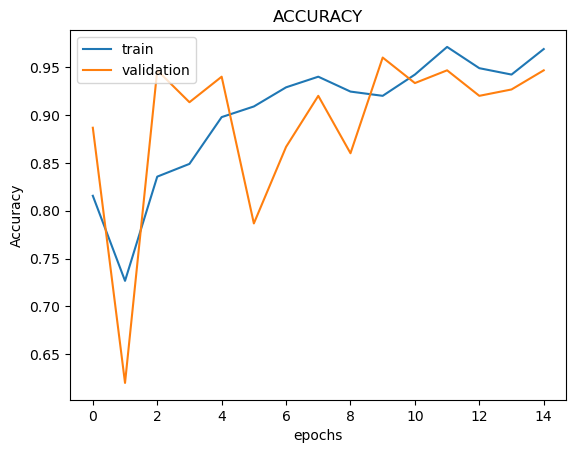

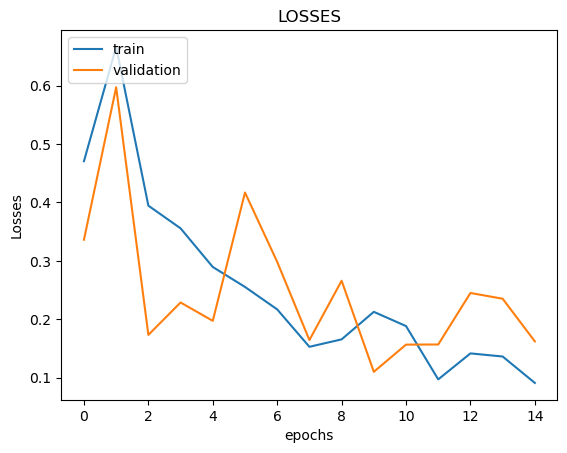

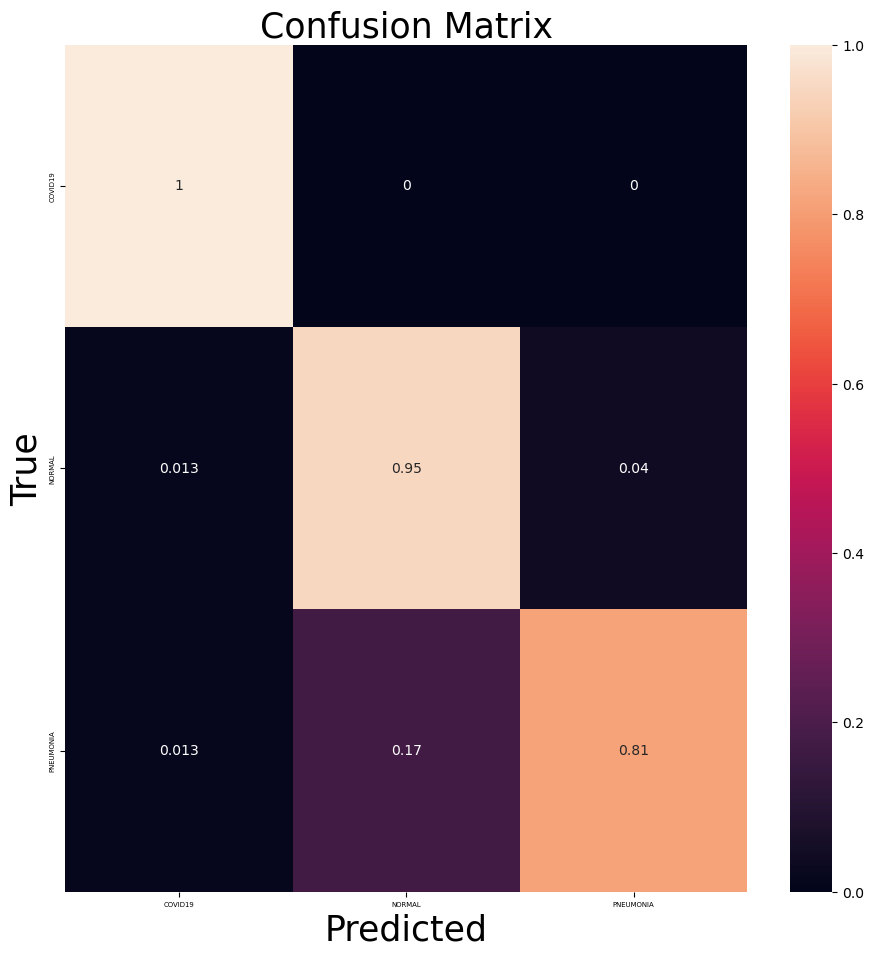

In [31]:
# TODO: YOUR SOLUTIONS HERE
model_dir = "/projects/scc/UGOE/UXEI/UMIN/scc_umin_pape/scc_umin_pape_dlforcv2526/dir.project/models/Ex3/model_weights"
weights_path = os.path.join(model_dir, "resnet50-0676ba61.pth")

model = torchvision.models.resnet50(weights=None)  # or pretrained=False in older torchvision

# Load the state dictionary
state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)
# Let's replace the "fully connected" layer to match our expected output classes
model.fc = nn.Linear(2048, 3)
model.to(device)

model_name = "ResNet50_Imagetrained"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()

print("Starting training from scratch with network: ", model_name)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer)

early_stopping = utils.EarlyStopping(checkpoint_path)

accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, model, 30, criterion, optimizer, scheduler, early_stopping, device)

utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")
utils.get_metric_plots(losses, val_losses, "Losses")

model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
model = model.to(device)

correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, model, device)
utils.check_precision_recall_accuracy(cm, classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)


# HINT:
#    - Training a ResNet50 (updating all the layers, transfer learning using ImageNet weights)
#    = (the training workflows are the same as above)

Now let's try the second approach and finetune only the last layer.

By default all parameters of a network will be updated by gradient descent. The gradient updates can be disabled by setting `requires_grad = False`. So in order to finetune only the last layer you need to `requires_grad = False` for all other layers in the network.

You can see how the parameters are disabled for a complete model in the code snippet below. For the next exercise you need to make sure that `requires_grad` stays `True` for the last layer!

```python
for param_name, param in model.named_parameters():
    param.requires_grad = False
```

The model checkpoint will be saved here:  ./covid-19-ResNet50_Imagetrained-from-scratch.pt
Starting training from scratch with network:  ResNet50_Imagetrained
450/450: [==============================>.] - ETA 0.3s
Epoch: 1
Training Loss: 1.071 , Training Accuracy:0.424 => Validation Loss: 0.987, Validation Accuracy: 0.647 
450/450: [==============================>.] - ETA 0.3s
Epoch: 2
Training Loss: 0.967 , Training Accuracy:0.582 => Validation Loss: 0.879, Validation Accuracy: 0.720 
450/450: [==============================>.] - ETA 0.3s
Epoch: 3
Training Loss: 0.891 , Training Accuracy:0.702 => Validation Loss: 0.785, Validation Accuracy: 0.827 
450/450: [==============================>.] - ETA 0.3s
Epoch: 4
Training Loss: 0.811 , Training Accuracy:0.758 => Validation Loss: 0.737, Validation Accuracy: 0.827 
450/450: [==============================>.] - ETA 0.2s
Epoch: 5
Training Loss: 0.750 , Training Accuracy:0.787 => Validation Loss: 0.663, Validation Accuracy: 0.867 
450/450: [=

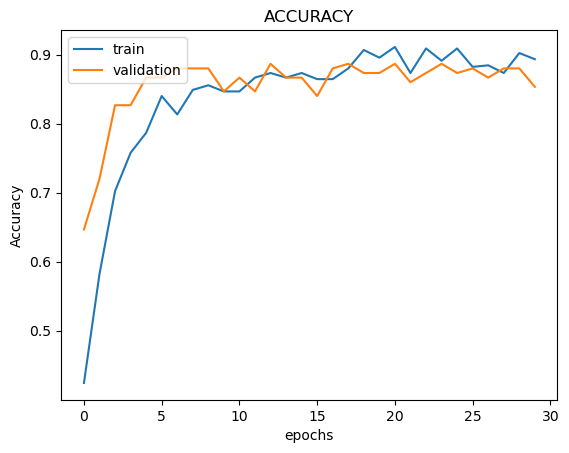

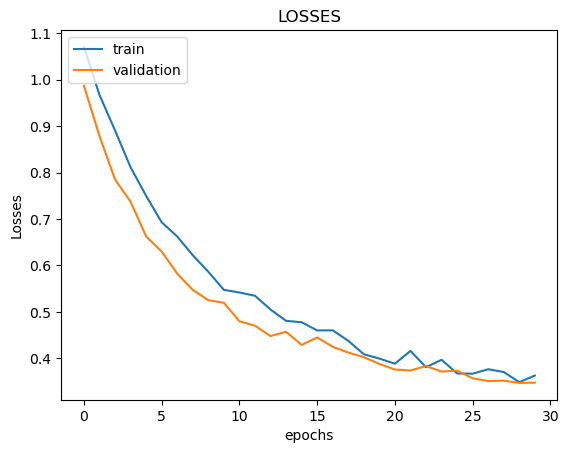

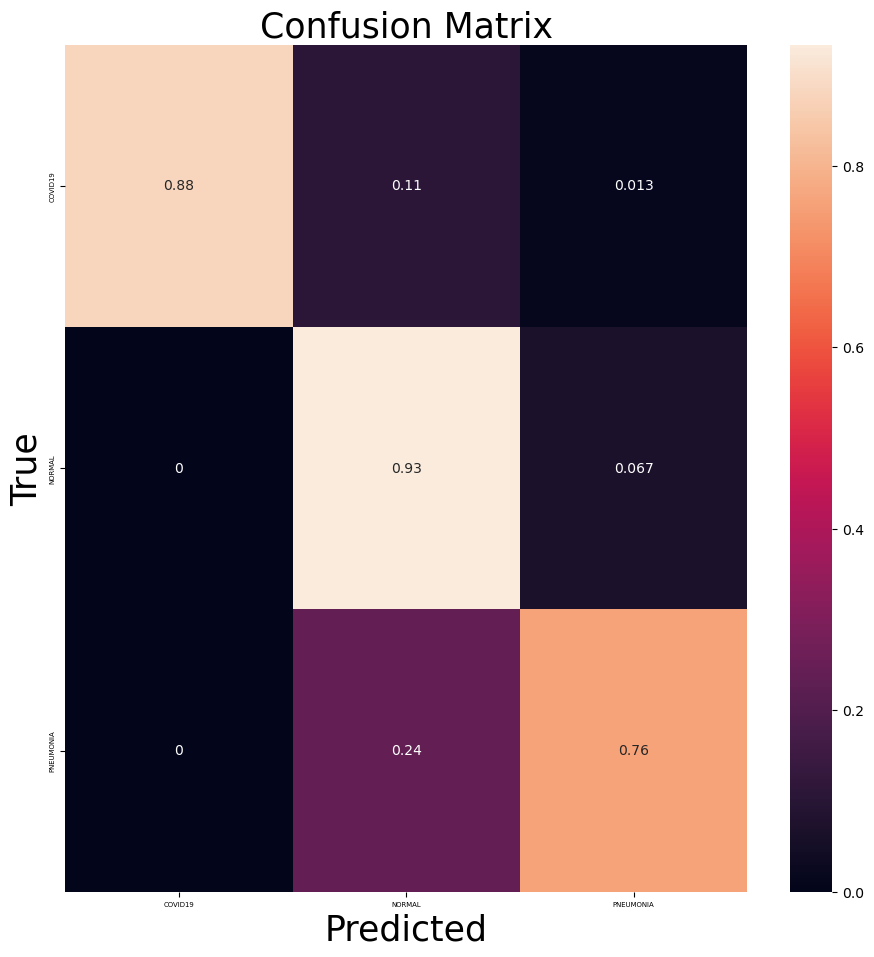

In [32]:
# TODO: YOUR SOLUTIONS HERE
model_dir = "/projects/scc/UGOE/UXEI/UMIN/scc_umin_pape/scc_umin_pape_dlforcv2526/dir.project/models/Ex3/model_weights"
weights_path = os.path.join(model_dir, "resnet50-0676ba61.pth")

model = torchvision.models.resnet50(weights=None)  # or pretrained=False in older torchvision

# Load the state dictionary
state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)

for param_name, param in model.named_parameters():
    param.requires_grad = False

# Let's replace the "fully connected" layer to match our expected output classes
model.fc = nn.Linear(2048, 3)

for param in model.fc.parameters():
    param.requires_grad = True

model.to(device)

model_name = "ResNet50_Imagetrained"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()

print("Starting training from scratch with network: ", model_name)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer)

early_stopping = utils.EarlyStopping(checkpoint_path)

accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, model, 30, criterion, optimizer, scheduler, early_stopping, device)

utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")
utils.get_metric_plots(losses, val_losses, "Losses")

model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
model = model.to(device)

correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, model, device)
utils.check_precision_recall_accuracy(cm, classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

# HINT:
#    - Training a ResNet50 (updating the last layers, transfer learning using ImageNet weights)
#    = (the training workflows are the same as above)

**Questions**:

1. Elaborate on the reason to use pretrained ImageNet weights for transfer learning (instead of training from scratch).
2. Which transfer learning approach performs better for finetuning on our dataset? Comment on the possible reasons!
3. Explain the best use-cases for ImageNet pretrained weights for the two different approaches (i.e. when it is a good idea to train from scratch OR for finetuning all layers OR for finetuning last layers).

**Answers**:
1. We can use pretrained models so that the weights are already slightly optimized to be used on images so that after training with our data we can get better results than training with random weights.
2. The first method performed the best so when we use pretrained weights and trained the whole model with our data. The reason is that training the whole model makes the whole model better at predicting that type of image. By only training the final layer it does not know enough.
3. It is a good idea to train from scratch when there are no pretrained weights that are similar to the training data and our data size is large. Finetuning all layers is useful when we have similar training data and want to make it better at predicting our data and our data size is medium. Finetuning the last layers is useful for a model when the training data is very similar to the pretrained data and our data size is small.

**Comment:** When finetuning a model it may also be beneficial to use a different learning rate and change other hyperparameters compared to training from scratch. To keep the exercise simple we do not further explore these options here. If you're interested to investigate these effects you can explore different hyperparameters at the end of the exercise.

## RadImageNet

A disadvantage of using ImageNet pretraining for medical images is that the pretraining data is very different to medical images. There are several efforts to build pretraining datasets for the medical image domain, for example [RadImageNet](https://www.radimagenet.com/).
It contains a pretraining dataset made up of radiology images of a comparable size to ImageNet and provides networks that were pretrained with this dataset.
- For more details you can check out the [RadImageNet publication](https://doi.org/10.1148/ryai.210315).

Note: if you use on RadImageNet weights you will have to use the statistics below for normalization (corresponding to the image statistics of the RadImageNet dataset):
```python
# Normalization: mean and standard deviation values for the pretrained weights on RadImageNet dataset
radimagenet_mean = (0.223, 0.223, 0.223)
radimagenet_std = (0.203, 0.203, 0.203)
```

We now use pretrained RadImageNet weights for the ResNet50. For this we first need to get the weights (they were previously downloaded for you) and initialize the model.

In [33]:
# DO NOT CHANGE
radimagenet_checkpoint_path = os.path.join(model_dir, "RadImageNet_pytorch")

resnet50_ckpt = torch.load(os.path.join(radimagenet_checkpoint_path, "ResNet50.pt"), weights_only=True)

In [34]:
# DO NOT CHANGE
# We create the backbone to intialize it with the pretrained weights from RadImageNet
class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = torchvision.models.resnet50()
        encoder_layers = list(base_model.children())
        self.backbone = nn.Sequential(*encoder_layers[:9])
                        
    def forward(self, x):
        return self.backbone(x)


# We build the classifier to use the features for transfer learning
class Classifier(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.drop_out = nn.Dropout()
        self.linear = nn.Linear(2048, num_class)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear(x)
        return x

## Architecture

We now combine the backbone (ResNet50 pretrained on RadImageNet) and the classification layer for our dataset.

Train and evaluate this model. You can decide whether to finetune the whole model or just the last layer.

In [35]:
# Let's call the backbone (the encoder excluding the last layers)
backbone = Backbone()

# Loading the pretrained weights to the backbone
backbone.load_state_dict(resnet50_ckpt)

# Now let's call the expected fully connected layer
classifier = Classifier(num_class=len(classes))

# Finally, we are ready to build our model 
net = nn.Sequential(backbone, classifier).to(device)


Training only the classifier (feature extractor mode).
450/450: [==============================>.] - ETA 0.2s
Epoch: 1
Training Loss: 1.107 , Training Accuracy:0.378 => Validation Loss: 1.059, Validation Accuracy: 0.553 
Validation Loss Decreased (inf --> 1.058524).  Saving model ...
450/450: [==============================>.] - ETA 0.2s
Epoch: 2
Training Loss: 1.041 , Training Accuracy:0.567 => Validation Loss: 1.013, Validation Accuracy: 0.680 
Validation Loss Decreased (1.058524 --> 1.013374).  Saving model ...
450/450: [==============================>.] - ETA 0.2s
Epoch: 3
Training Loss: 0.995 , Training Accuracy:0.538 => Validation Loss: 0.970, Validation Accuracy: 0.727 
Validation Loss Decreased (1.013374 --> 0.970190).  Saving model ...
450/450: [==============================>.] - ETA 0.2s
Epoch: 4
Training Loss: 0.947 , Training Accuracy:0.724 => Validation Loss: 0.935, Validation Accuracy: 0.667 
Validation Loss Decreased (0.970190 --> 0.935103).  Saving model ...
450/450: 

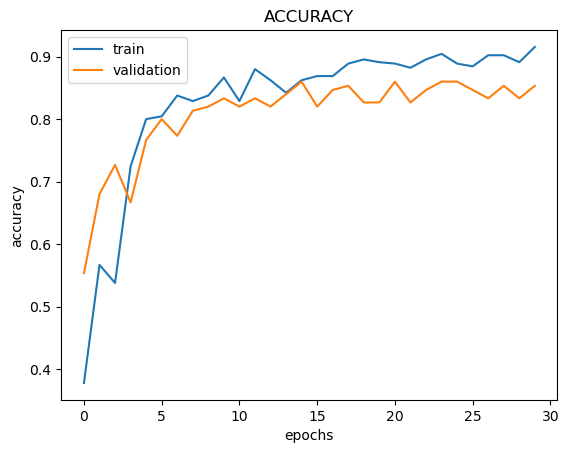

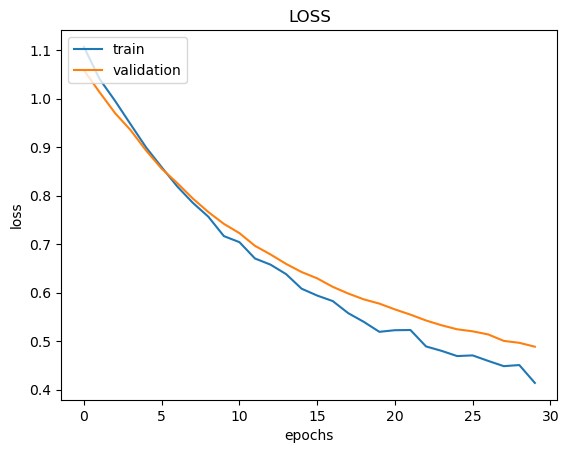

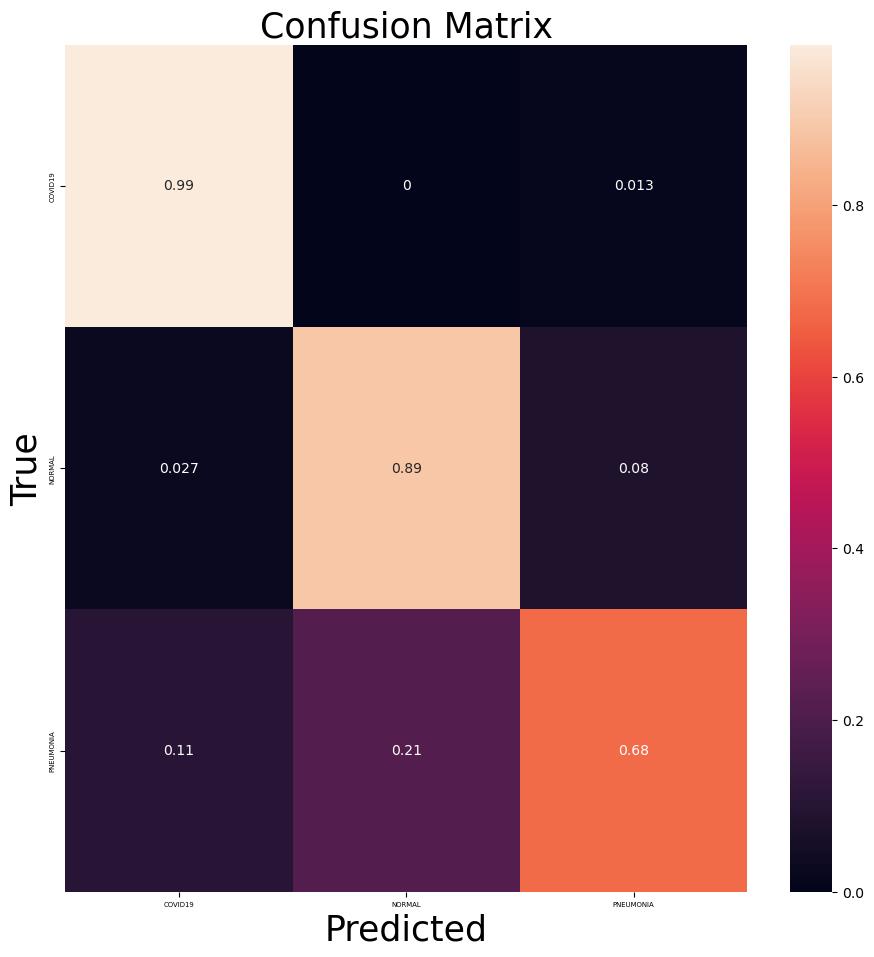

In [36]:
radimagenet_mean = (0.223, 0.223, 0.223)
radimagenet_std  = (0.203, 0.203, 0.203)

# DATA TRANSFORMS
train_tf = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.05, contrast=0.05, saturation=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=radimagenet_mean, std=radimagenet_std)
])

val_tf = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=radimagenet_mean, std=radimagenet_std)
])

test_tf = val_tf

# DATASETS + LOADERS
train_dataset = datasets.ImageFolder(train_dir, transform=train_tf)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_tf)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_tf)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)



# fine-tune all layers
# train_only_classifier = False

# train only the classifier
train_only_classifier = True


if train_only_classifier:
    print("\nTraining only the classifier (feature extractor mode).")
    for name, param in backbone.named_parameters():
        param.requires_grad = False
    for name, param in classifier.named_parameters():
        param.requires_grad = True
else:
    print("\nFine-tuning ALL RadImageNet layers.")
    for name, param in net.named_parameters():
        param.requires_grad = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer)

checkpoint_path = os.path.join(root_dir, "radimagenet-resnet50.pt")
early_stopping = utils.EarlyStopping(
    checkpoint_path=checkpoint_path,
    verbose=True
)


# TRAINING
num_epochs = 30

train_acc, val_acc, train_loss, val_loss = utils.run_training(
    train_loader=train_loader,
    val_loader=val_loader,
    net=net,
    num_epochs=num_epochs,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    early_stopping=early_stopping,
    device=device
)


# PLOTS
utils.get_metric_plots(train_acc, val_acc, metric_name="accuracy")
utils.get_metric_plots(train_loss, val_loss, metric_name="loss")


# TEST EVALUATION
backbone = Backbone()
backbone.load_state_dict(resnet50_ckpt)
classifier = Classifier(num_class=len(classes))
best_net = nn.Sequential(backbone, classifier)
best_net.load_state_dict(torch.load(checkpoint_path, map_location=device))

best_net = best_net.to(device)
best_net.eval()

correct, total = utils.test_evaluation(best_net, test_loader, device)
print(f"\nTest Accuracy (RadImageNet ResNet50): {100 * correct / total:.2f}%")

cm = utils.get_confusion_matrix(classes, test_loader, best_net, device)
utils.check_precision_recall_accuracy(cm, classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

**Questions**:

1. Comment on your choice of transfer learning approach (either finetuning last layers / all layers in the model) for RadImageNet? Why could the best approach here be different from ImageNet?

**Answers**:
1. Here we have used fine-tuning the last layers due to RadNetImage being a dataset of medical images which are similiar to our datasets so we can just train the last layer and not have to train the entire model. RadNetImage is medical data and ImageNet is not.

### Overall Results:

Update the table with your results for all experiments from the exercise:

| Model    | Training                         | Test Accuracy |
|:-------: |:--------------------------------:|:-------------:|
| ResNet18 | from scratch                     |      89 %     |
| ResNet34 | from scratch                     |      87 %     |
| ResNet50 | from scratch                     |      84 %     |
| ResNet50 | from scratch (with augmentation) |      85 %     |
| ResNet50 | from ImageNet (all layers)       |      92 %     |
| ResNet50 | from ImageNet (last layers)      |      85 %     |
| ResNet50 | from RadImageNet                 |      85.33 %  |

**Question**:
1. Comment on the trend observed in the results from the table.
2. Which is the overall best model? Does this match your expectations? Why/why not?

**Important: Please read the end of the exercise sheet and upload the predictions from your best model, also if you choose not to try out to further improve it.**

**Answers**:
1. All the methods applied to the ResNet50 have improved the performance of the model. Both models that did not use ResNet50 were better than all except one variation of ResNet50.
2. ResNet50 from ImageNet with all layers being trained was the best model. The general trend of ResNet50 was expected. It was not expected that RadImage was the same as ImageNet when using the last layer. It was also not expected that ResNet18 and ResNet34 would be better than ResNet50.

## Further improve your model (*Optional*)

You can now try to further improve the model by using different architectures or trying some of the advanced training and inference techniques discussed in the lecture. This part of the exercise is optional, and you can try to apply as many approaches for improving your method as you would like. If you don't want to work on the optional part at all please go to the end of the exercise to submit the predictions from your best model.

Here are the aproaches you can try to improve the model:
1. Update the training hyperparameter:
    - You can choose a better initial learning rate, or choose different options for the learning rate scheduler or early stopping.
    - The most important parameter is probably the learning rate; if you want to improve it then train only for a short time and compare different values. (Remember lecture 2 and the first exercise). 
2. Try other architectures provided in `torchvision.models`, which implements further CNN architectures (and their respective ImageNet pretrained weights). For example `DenseNet` or `EfficientNet` could yield better results than ResNets.
    - `torchvision.models` also offers vision transformer architectures (https://arxiv.org/abs/2010.11929). We will cover those later in the lecture, but if you want you can try them here as well. See the snippet at the end of this section for details. 
3. Try advanced data augmentation strategies, which change the data manifold severly and can boost performance. For example MixUp or CutMix. `torchivsion` already implements them, see [data augmentation with torchvision](https://pytorch.org/vision/stable/transforms.html) for details.
4. Try test-time data augmentation. We have covered this idea in the lecture. To use it you don't need to change the training at all, but just update the model prediction during testing. Fot this you can either update the functionality in `ex3_utils.py` or implement a wrapper function or class around the model that implements the test-time data augmentation logic.
5. Try model ensembling: combine the predictions of different models on the test set or use an implicit averaging approach like polyak averaging. For this approaches you may need to update the training and/or prediction functions from `ex3_utils.py`.

Here's a snippet that shows how to use vision transformers from torchvision:

```python
# replacing the respective layers of the "transformer-based networks" to match our number of classes
net = torchvision.models.vit_b_16(pretrained=True)
net.heads.head = nn.Linear(768, num_classes)
net.to(device)
```

**Hint**: if you want to systematically improve your model you should proceed as follows:
- Decide on the base architecture and how to initialize it.
    - Either choose the best model you according to the exercise so far or try if advanced architectures from `torchvision` bring an improvement and continue with one of them.
- Optimize the training hyperparameters (learning rate, scheduling, early stopping).
- Investigate advanced techniques:
  - Training with more or advanced data augmentation.
  - Test-time data augmentation
  - Model ensembling

You can divide some of these tasks up among your group and train the best model by combining the best settings you have found for the individual steps.

## Train your best model

In [37]:
# TODO: IMPLEMENT AND TRAIN THE BEST MODEL HERE